In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

plt.ion()

In [4]:
class Net(nn.Module):
    """
    Generic MLP with one hidden layer and tanh activation.
    l1, l2, l3 are sizes of input, hidden, and output layer, respectively.
    Note that there are two components in the output layer, corresponding to mean and log(sigma^2), respectively
    """
    def __init__(self, l1, l2, l3):
        super(Net, self).__init__()
        self.fc_h = nn.Linear(l1, l2)
        self.fc_mean = nn.Linear(l2, l3)
        self.fc_log_sigma2 = nn.Linear(l2, l3)
    
    def forward(self, x):
        h = F.tanh(self.fc_h(x))
        mean = self.fc_mean(h)
        log_sigma2 = self.fc_log_sigma2(h)
        return mean, log_sigma2

In [10]:
class VAE:
    """
    Variational autoencoder. Assumes normally distributed output x.
    dec_net and enc_net represent the decoder and encoder networks.
    """
    def __init__(self, z_dim, h_dim, x_dim, save_path = None):
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.x_dim = x_dim
        
        self.dec_net = Net(z_dim, h_dim, x_dim)
        self.enc_net = Net(x_dim, h_dim, z_dim)
        
        self.params = list(self.dec_net.parameters()) + list(self.enc_net.parameters())
        self.optimizer = optim.Adam(self.params, lr = 0.001)
        
        if save_path is not None: self.save_path = '../ckpts/' + save_path
        else: self.save_path = '../ckpts/vae_z={}_h={}_x={}/'.format(z_dim, h_dim, x_dim)
    
    def save_model(self):
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
        torch.save(self.dec_net.state_dict(), self.save_path + 'dec_net')
        torch.save(self.enc_net.state_dict(), self.save_path + 'enc_net')
        torch.save(self.optimizer.state_dict(), self.save_path + 'optimizer')
    
    def load_model(self):
        if not os.path.exists(self.save_path): return
        self.dec_net.load_state_dict(torch.load(self.save_path + 'dec_net'))
        self.enc_net.load_state_dict(torch.load(self.save_path + 'enc_net'))
        self.optimizer.load_state_dict(torch.load(self.save_path + 'optimizer'))
    
    def train(self, x_data, M = 100, L = 1, num_epochs = 100000, every_epoch = 100):
        """
        x_data is assumed to be a tensor of shape (N, x_dim)
        N is the amount of training data
        M is the minibatch size
        L is the number of samples in the Monte Carlo estimator
        num_epochs is number of passes through the training set
        """
        assert(x_data.size()[1] == self.x_dim)
        N = x_data.size()[0]

        self.log_likelihood_data = []
        for epoch in range(1, num_epochs + 1):
            log_likelihood = 0
            num_times = 0
            x_data = x_data[torch.randperm(N)]
            for i in range(0, N, M):
                self.optimizer.zero_grad()
                
                end = min(i + M, N)
                batch_data = x_data[i:end]
                loss = self.compute_loss(batch_data, N, L)
                log_likelihood -= loss.data[0] / N
                num_times += 1
                
                loss.backward()
                self.optimizer.step()
            
            log_likelihood /= num_times
            if epoch % every_epoch == 0:
                print("Epoch {} Marginal Log-Likelihood: {}".format(epoch, log_likelihood))
            self.log_likelihood_data.append(log_likelihood)
        
    def compute_loss(self, batch_data, N, L):
        """
        Computes loss to minimize with gradient descent.
        Negative of equation (10) in the paper.
        We also use a tanh activation on the mean output of the decoder network 
        to constrain it to the interval (-1, 1) (similar to the paper).
        """
        
        M = batch_data.size()[0]
        batch_data = Variable(batch_data)
        enc_mean, enc_log_sigma2 = self.enc_net(batch_data)
        enc_sigma2 = torch.exp(enc_log_sigma2)
        
        loss = -0.5 * torch.sum(1 + enc_log_sigma2 - enc_mean ** 2 - enc_sigma2)
        for l in range(L):
            eps = Variable(torch.randn(self.z_dim))
            z = enc_mean + enc_sigma2 * eps
            dec_mean, dec_log_sigma2 = self.dec_net(z)
            dec_sigma2 = torch.exp(dec_log_sigma2)
            dec_mean = torch.tanh(dec_mean)
            add1 = dec_log_sigma2 + np.log(2 * np.pi)
            add2 = ((batch_data - dec_mean) ** 2) / dec_sigma2
            loss += 0.5 / L * torch.sum(add1 + add2)
        
        return loss * N / M
    
    def sample_dec(self, z):
        """
        Returns a sample of the generative model, given the latent variable z
        """
        
        z = Variable(torch.unsqueeze(z, 0))
        dec_mean, dec_log_sigma2 = self.dec_net(z)
        dec_sigma2 = torch.exp(torch.squeeze(dec_log_sigma2.data))
        dec_mean = torch.tanh(torch.squeeze(dec_mean.data))
        x = torch.randn(self.x_dim)
        x = dec_mean# + dec_sigma2 * x
        return x
    
    def sample(self):
        """
        Returns a sample of the generative model (decoder network with isotropic Gaussian prior z)
        """
        
        z = torch.randn(self.z_dim)
        return self.sample_dec(z)


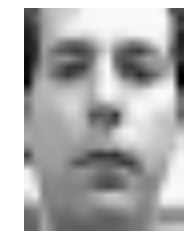

In [6]:
# We test the VAE on the frey face and MNIST datasets, like the paper.
import scipy.io
frey_data = scipy.io.loadmat('../data/frey_rawface.mat')
frey_data = frey_data['ff']
frey_data = np.transpose(frey_data)
frey_data = (frey_data.astype(float) - 128) / 128

def plot_frey(image, ax = plt):
    image = np.reshape(image, (28, 20)) * 128 + 128
    ax.imshow(image, cmap = 'gray')

plot_frey(frey_data[10])
plt.axis('off')
plt.show()


In [11]:
model_frey = VAE(z_dim = 2, h_dim = 200, x_dim = 560, save_path = 'vae_frey_z=2/')
model_frey.load_model()
#model_frey.train(torch.Tensor(frey_data))

In [91]:
model_frey.save_model()

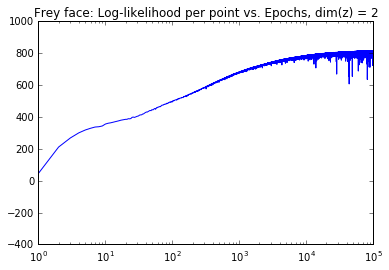

In [92]:
plt.plot(model_frey.log_likelihood_data)
plt.title('Frey face: Log-likelihood per point vs. Epochs, dim(z) = 2')
plt.xscale('log')
#plt.savefig('../results/frey_z=2.png')
plt.show()

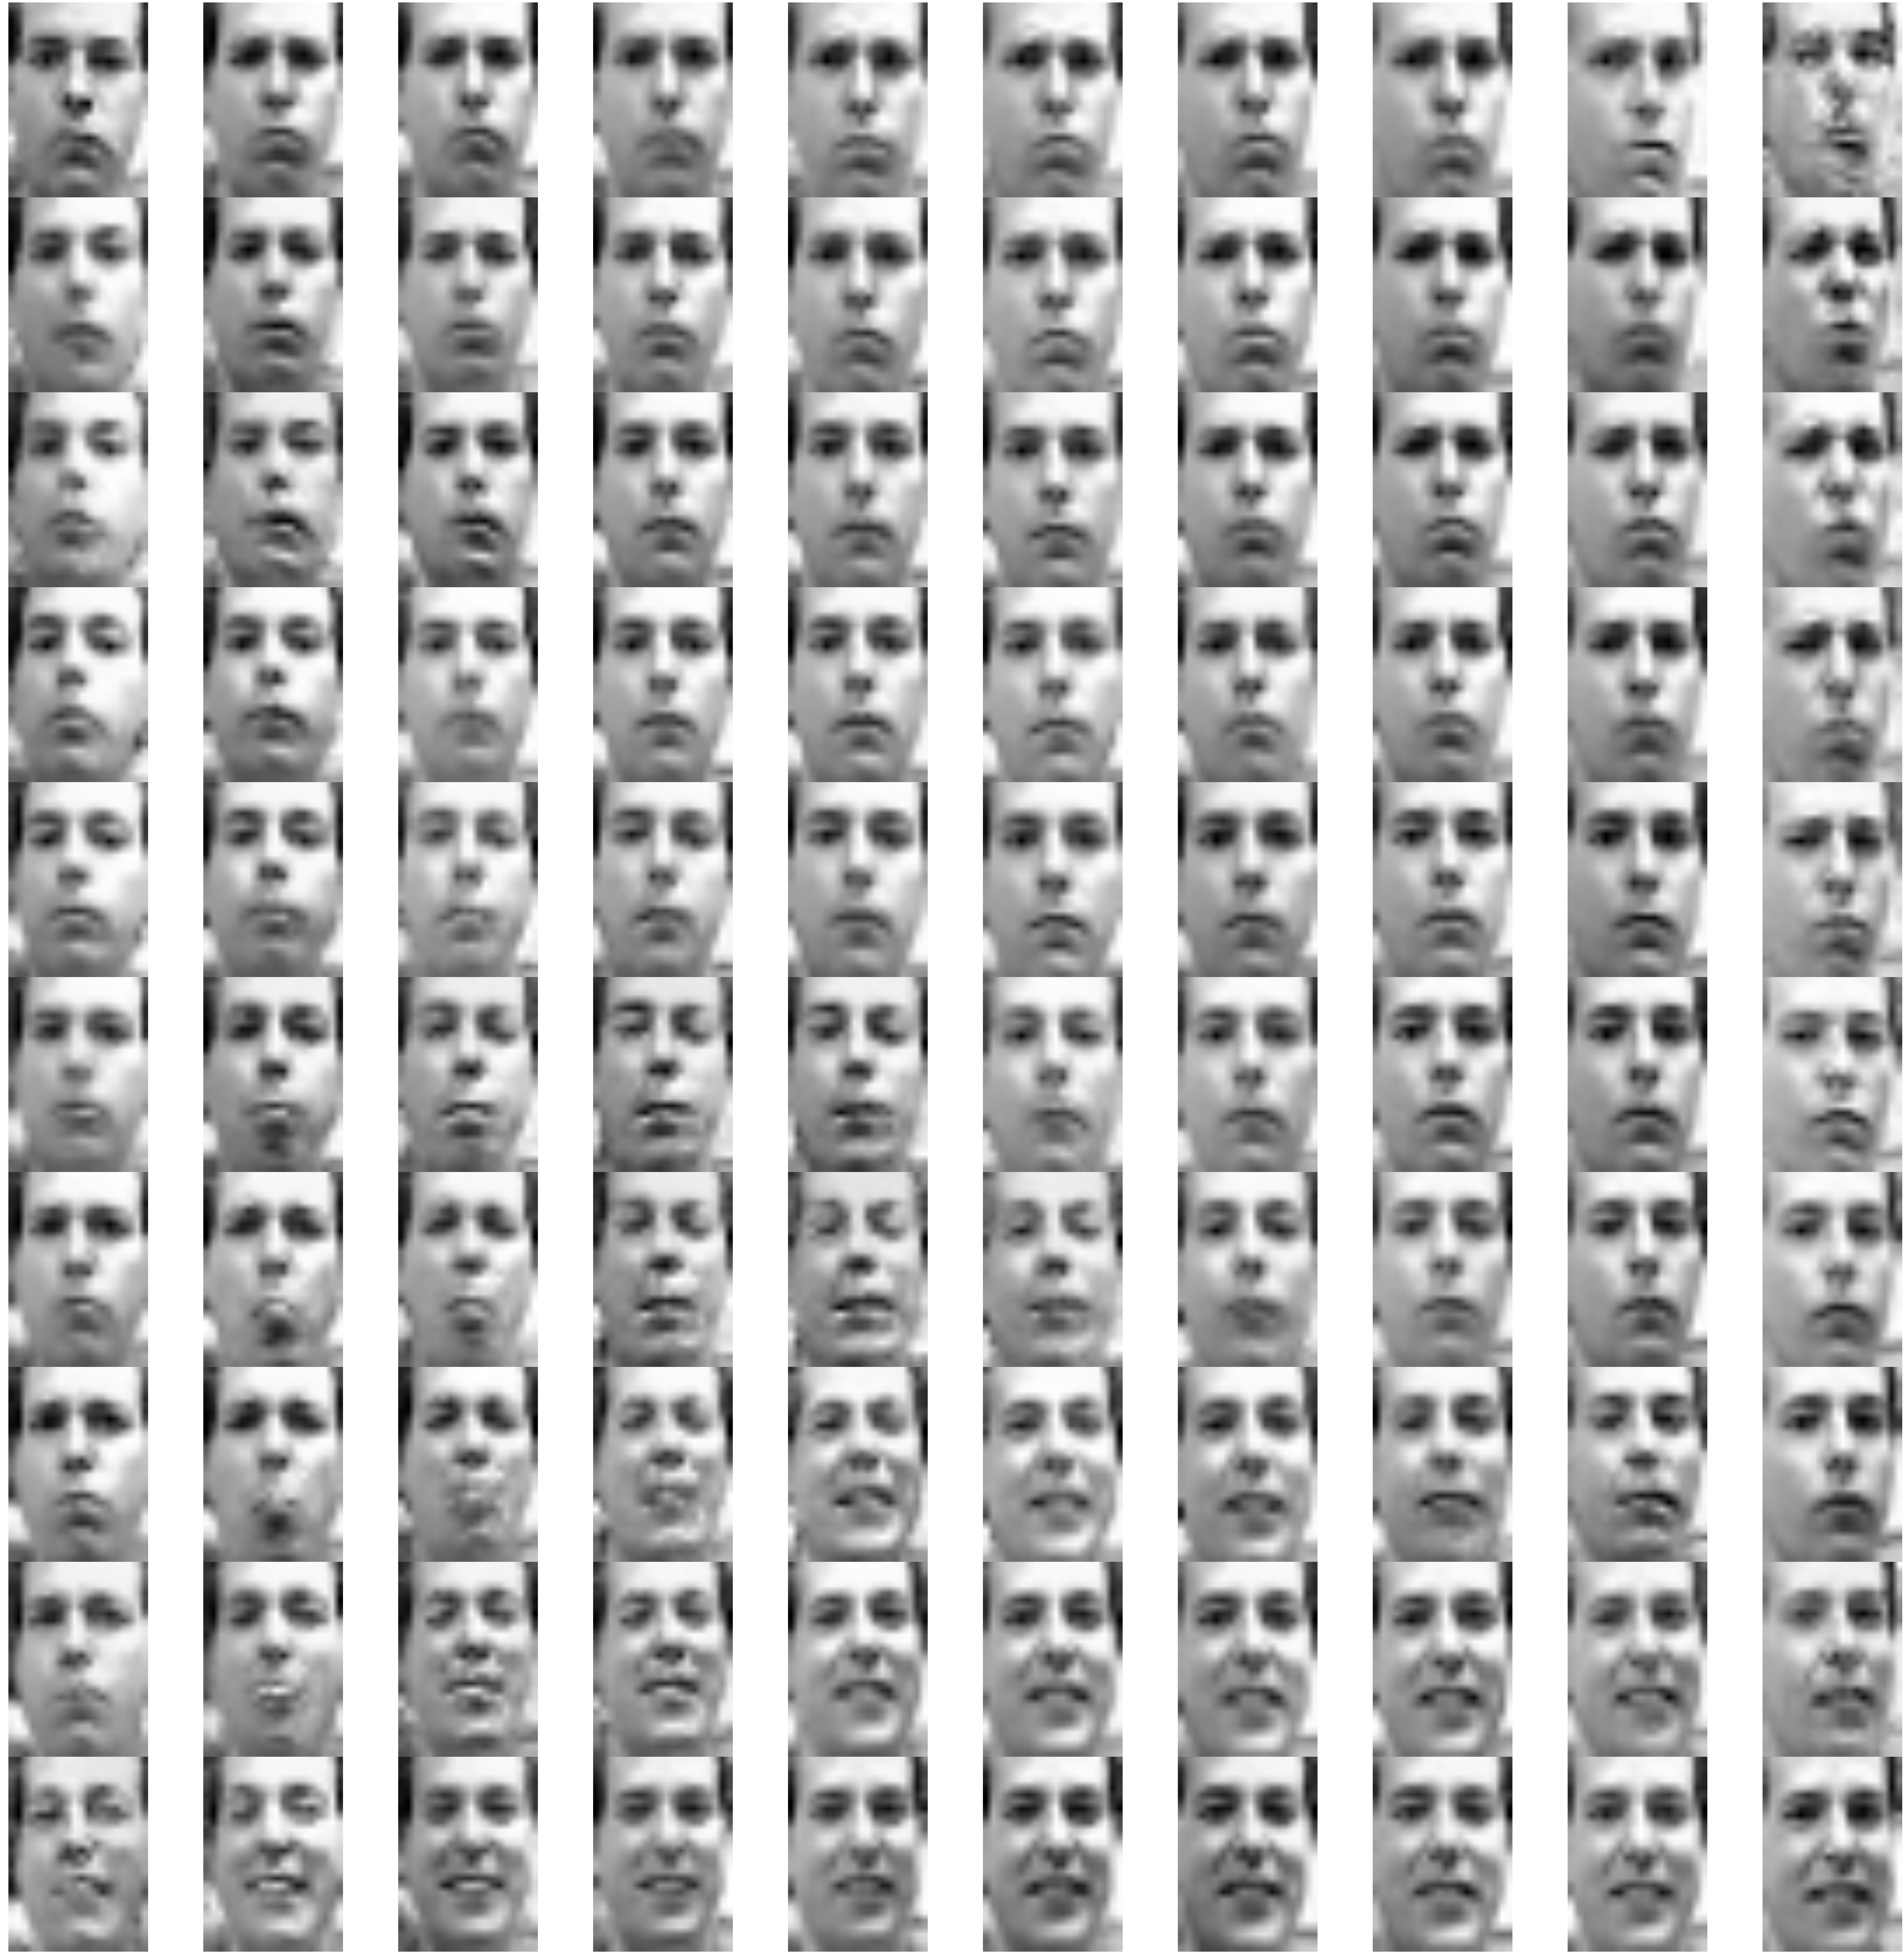

In [12]:
from scipy.stats import norm

fig, axes = plt.subplots(10, 10, figsize = (100, 100), gridspec_kw={'wspace' : 0, 'hspace': 0})
side = np.linspace(0.05, 0.95, 10)
X, Y = np.meshgrid(side, side)
X_ppf = norm.ppf(X)
Y_pff = norm.ppf(Y)

for x, y, ax in zip(X.flatten(), Y.flatten(), axes.flatten()):
    z = torch.Tensor([norm.ppf(x), norm.ppf(y)])
    x = model_frey.sample_dec(z).numpy()
    plot_frey(x, ax)
    ax.axis('off')

#fig.subplots_adjust(wspace = 0, hspace = 0)
plt.show()